In [0]:
import mlflow

# Use MLflow to track experiments
mlflow.set_experiment("/Users/jcharley@microsoft.com/databricks_automl/EmployeeTargeted_training_dataset_numeric-2021_08_03-10_57")

target_col = "EmployeeTargeted"

## Load Data

In [0]:
import os
import uuid
import shutil
import pandas as pd

from mlflow.tracking import MlflowClient

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)

# Download the artifact and read it into a pandas DataFrame
input_client = MlflowClient()
input_data_path = input_client.download_artifacts("1e84ba7bc5cd47c087e2c0cee9d95c7b", "data", input_temp_dir)
df_loaded = pd.read_parquet(os.path.join(input_data_path, "training_data"))

# Delete the temp data
shutil.rmtree(input_temp_dir)

# Preview data
df_loaded.head(5)

,Access_Level,Training_Completed,Code_postal,EmployeeTargeted,Gender,Social_Media,behaviorPattern2,peerUsageMetric6,usageMetric2,usageMetric5,fraudTraining
0,4,1.0,10000,1,0,2.0,1,6,0,4,1
1,2,1.0,84995,0,0,1.0,0,5,1,6,1
2,2,1.0,10000,1,0,0.0,0,0,0,4,1
3,3,0.0,24999,1,1,0.0,2,6,0,6,0
4,2,1.0,24999,1,1,1.0,2,3,1,5,0


## Preprocessors

In [0]:
transformers = []

### Numerical columns

Missing values for numerical columns are imputed with mean for consistency

In [0]:
from sklearn.impute import SimpleImputer

transformers.append(("numerical", SimpleImputer(strategy="mean"), ['Gender', 'Training_Completed', 'fraudTraining', 'Access_Level', 'Code_postal', 'Social_Media', 'behaviorPattern2', 'peerUsageMetric6', 'usageMetric2', 'usageMetric5']))

In [0]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

### Feature standardization
Scale all feature columns to be centered around zero with unit variance.

In [0]:
from sklearn.preprocessing import StandardScaler

standardizer = StandardScaler()

## Training - Validation Split
Split the input data into training and validation data

In [0]:
from sklearn.model_selection import train_test_split

split_X = df_loaded.drop([target_col], axis=1)
split_y = df_loaded[target_col]

X_train, X_val, y_train, y_val = train_test_split(split_X, split_y, random_state=461383267, stratify=split_y)

## Train classification model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/2306030850866054/s?orderByKey=metrics.%60val_f1_score%60&orderByAsc=false)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment
- To view the full list of tunable hyperparameters, check the output of the cell below

In [0]:
from xgboost import XGBClassifier


Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective='binary:logistic', use_label_encoder=True, **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of boosting rounds.
 |      use_label_encoder : bool
 |          (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new
 |          code, we recommend that you set this parameter to False.
 |  
 |      max_depth : int
 |          Maximum tree depth for base learners.
 |      learning_rate : float
 |          Boosting learning rate (xgb's "eta")
 |      verbosity : int
 |          The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |      objective : string or callable
 |          Specify the learning task and the corresponding learning objective or
 |          a custom objective func

In [0]:
import mlflow
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline

set_config(display='diagram')

xgbc_classifier = XGBClassifier(
  learning_rate=0.03932251755944412,
  max_depth=10,
  min_child_weight=12,
  subsample=0.4239478664780319,
  random_state=461383267,
)

model = Pipeline([
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
    ("classifier", xgbc_classifier),
])

model

Pipeline Pipeline(steps=[('preprocessor',
 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('numerical', SimpleImputer(),
 ['Gender',
 'Training_Completed',
 'fraudTraining',
 'Access_Level',
 'Code_postal',
 'Social_Media',
 'behaviorPattern2',
 'peerUsageMetric6',
 'usageMetric2',
 'usageMetric5'])])),
 ('standardizer', StandardScaler()),
 ('classifier',
 XG...
 interaction_constraints=None,
 learning_rate=0.03932251755944412,
 max_delta_step=None, max_depth=10,
 min_child_weight=12, missing=nan,
 monotone_constraints=None, n_estimators=100,
 n_jobs=None, num_parallel_tree=None,
 random_state=461383267, reg_alpha=None,
 reg_lambda=None, scale_pos_weight=None,
 subsample=0.4239478664780319, tree_method=None,
 validate_parameters=None, verbosity=None))]) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('numerical', SimpleImputer(),
 ['Gender', 'Training_Completed',
 'fraudTraining', 'Access_Level',
 'Code_postal', 'Social_Media',
 'behaviorPattern2', 'peerUsageMetric6',
 'usageMetric2', 'usageMetric5'])]) numerical ['Gender', 'Training_Completed', 'fraudTraining', 'Access_Level', 'Code_postal', 'Social_Media', 'behaviorPattern2', 'peerUsageMetric6', 'usageMetric2', 'usageMetric5'] SimpleImputer SimpleImputer() StandardScaler StandardScaler() XGBClassifier XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
 colsample_bynode=None, colsample_bytree=None, gamma=None,
 gpu_id=None, importance_type='gain', interaction_constraints=None,
 learning_rate=0.03932251755944412, max_delta_step=None,
 max_depth=10, min_child_weight=12, missing=nan,
 monotone_constraints=None, n_estimators=100, n_jobs=None,
 num_parallel_tree=None, random_state=461383267, reg_alpha=None,
 reg_lambda=None, scale_pos_weight=None,
 subsample=0.4239478664780319, tree_method=None,
 validate_parameters=None, verbosity=None)

In [0]:
# Enable automatic logging of input samples, metrics, parameters, and models
mlflow.sklearn.autolog(log_input_examples=True, silent=True)

with mlflow.start_run(run_name="xgboost") as mlflow_run:
    model.fit(X_train, y_train)
    
    # Training metrics are logged by MLflow autologging
    # Log metrics for the validation set
    xgbc_val_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_val, y_val,
                                                                prefix="val_")
    display(pd.DataFrame(xgbc_val_metrics, index=[0]))

/databricks/conda/envs/databricks-ml/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,val_precision_score,val_recall_score,val_f1_score,val_accuracy_score,val_log_loss,val_roc_auc_score,val_score
0,0.905494,0.907048,0.905242,0.907048,0.294058,0.903304,0.907048


In [0]:
# Patch requisite packages to the model environment YAML for model serving
import os
import shutil
import uuid
import yaml

None

import xgboost
from mlflow.tracking import MlflowClient

xgbc_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], str(uuid.uuid4())[:8])
os.makedirs(xgbc_temp_dir)
xgbc_client = MlflowClient()
xgbc_model_env_path = xgbc_client.download_artifacts(mlflow_run.info.run_id, "model/conda.yaml", xgbc_temp_dir)
xgbc_model_env_str = open(xgbc_model_env_path)
xgbc_parsed_model_env_str = yaml.load(xgbc_model_env_str, Loader=yaml.FullLoader)

xgbc_parsed_model_env_str["dependencies"][-1]["pip"].append(f"xgboost=={xgboost.__version__}")

with open(xgbc_model_env_path, "w") as f:
  f.write(yaml.dump(xgbc_parsed_model_env_str))
xgbc_client.log_artifact(run_id=mlflow_run.info.run_id, local_path=xgbc_model_env_path, artifact_path="model")
shutil.rmtree(xgbc_temp_dir)

## Feature importance

SHAP is a game-theoretic approach to explain machine learning models, providing a summary plot
of the relationship between features and model output. Features are ranked in descending order of
importance, and impact/color describe the correlation between the feature and the target variable.
- To reduce the computational overhead of each trial, a single example is sampled from the validation set to explain.<br />
  For more thorough results, increase the sample size of explanations, or provide your own examples to explain.
- SHAP cannot explain models using data with nulls; if your dataset has any, both the background data and
  examples to explain will be imputed using the mode (most frequent values). This affects the computed
  SHAP values, as the imputed samples may not match the actual data distribution.

For more information on how to read Shapley values, see the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

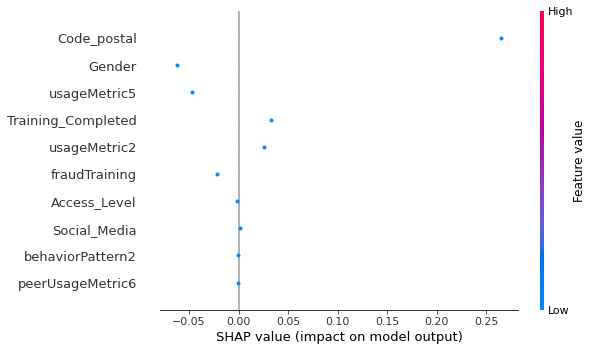

In [0]:
from shap import KernelExplainer, summary_plot

try:
    # To enable SHAP to succeed, both the background data and examples to explain are imputed with the mode (most frequent values).
    mode = X_train.mode().iloc[0]

    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, len(X_train.index))).fillna(mode)

    # Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
    example = X_val.sample(n=1).fillna(mode)

    # Use Kernel SHAP to explain feature importance on the example from the validation set.
    predict = lambda x: model.predict(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="identity")
    shap_values = explainer.shap_values(example, l1_reg=False)
    summary_plot(shap_values, example)
except Exception as e:
    print(f"An unexpected error occurred while plotting feature importance using SHAP: {e}")

## Inference
[The MLflow Model Registry](https://docs.databricks.com/applications/mlflow/model-registry.html) is a collaborative hub where teams can share ML models, work together from experimentation to online testing and production, integrate with approval and governance workflows, and monitor ML deployments and their performance. The snippets below show how to add the model trained in this notebook to the model registry and to retrieve it later for inference.

> **NOTE:** The `model_uri` for the model already trained in this notebook can be found in the cell below

### Register to Model Registry
```
model_name = "Example"

model_uri = f"runs:/{ mlflow_run.info.run_id }/model"
registered_model_version = mlflow.register_model(model_uri, model_name)
```

### Load from Model Registry
```
model_name = "Example"
model_version = registered_model_version.version

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")
model.predict(input_X)
```

### Load model without registering
```
model_uri = f"runs:/{ mlflow_run.info.run_id }/model"

model = mlflow.pyfunc.load_model(model_uri)
model.predict(input_X)
```

In [0]:
# model_uri for the generated model
print(f"runs:/{ mlflow_run.info.run_id }/model")

runs:/ff7284a49c724ed0913b7ff6db0d3733/model
